###### [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/adaptive-intelligent-robotics/QDax/blob/main/notebooks/cmamega_example.ipynb)

# Optimizing with CMA-ME in Jax

This notebook shows how to use QDax to find diverse and performing parameters on the Rastrigin problem with [CMA-ME](https://arxiv.org/pdf/1912.02400.pdf). It can be run locally or on Google Colab. We recommand to use a GPU. This notebook will show:

- how to define the problem
- how to create a CMA-ME emitter
- how to create a Map-elites instance
- which functions must be defined before training
- how to launch a certain number of training steps
- how to visualise the optimization process

In [28]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [29]:
import math

import jax 
import jax.numpy as jnp

try:
    import flax
except:
    !pip install --no-deps git+https://github.com/google/flax.git@v0.4.1 |tail -n 1
    import flax

try:
    import chex
except:
    !pip install --no-deps git+https://github.com/deepmind/chex.git@v0.1.3 |tail -n 1
    import chex
    
try:
    import qdax
except:
    !pip install --no-deps git+https://github.com/adaptive-intelligent-robotics/QDax@main |tail -n 1
    import qdax

from qdax.core.map_elites import MAPElites
from qdax.core.emitters.cma_emitter import CMAEmitter
from qdax.core.emitters.cma_opt_emitter import CMAOptimizingEmitter
from qdax.core.emitters.cma_rnd_emitter import CMARndEmitter
from qdax.core.emitters.cma_multi_emitter import CMAPoolEmitter
from qdax.core.emitters.standard_emitters import MixingEmitter
from qdax.core.containers.mapelites_repertoire import compute_euclidean_centroids, MapElitesRepertoire
# from qdax.utils.plotting import plot_map_elites_results
from qdax.utils.plotting import plot_multidimensional_map_elites_grid

from typing import Dict

In [30]:
# from jax.config import config

# config.update('jax_disable_jit', True)

## Set the hyperparameters

Most hyperparameters are similar to those introduced in [Differentiable Quality Diversity paper](https://arxiv.org/pdf/2106.03894.pdf).

In [89]:
#@title QD Training Definitions Fields
#@markdown ---
num_iterations = 500 #70000 #10000
num_dimensions = 2 #1000 #@param {type:"integer"} # try 20 and 100
# num_centroids = 10000 #@param {type:"integer"}
grid_shape = (100, 100) # (500, 500) 
batch_size = 500 #36 #@param {type:"integer"}
sigma_g = 1. #@param {type:"number"}
minval = -5.12 #@param {type:"number"}
maxval = 5.12 #@param {type:"number"}
min_bd = -5.12 * 0.5 * num_dimensions #@param {type:"number"}
max_bd = 5.12 * 0.5 * num_dimensions #@param {type:"number"}
num_emitters = 3
#@markdown ---

Mean:  [-1.4894105 -1.4662077]
Cov:  [[ 1.1768104  -0.84738123]
 [-0.84738123  1.6543992 ]]
Mean:  [0.6950015 0.5789492]
Cov:  [[ 2.4463491 -0.747664 ]
 [-0.747664   2.9764245]]
Mean:  [ 1.841203  -1.5362676]
Cov:  [[0.44296604 0.09660298]
 [0.09660298 0.09422725]]


## Defines the scoring function: rastrigin or sphere

In [90]:
def rastrigin_scoring(x: jnp.ndarray):
    first_term = 10 * x.shape[-1]
    second_term = jnp.sum((x + minval * 0.4) ** 2 - 10 * jnp.cos(2 * jnp.pi * (x + minval * 0.4)))
    return -(first_term + second_term)

def sphere_scoring(x: jnp.ndarray):
    return -jnp.sum((x + minval * 0.4) * (x + minval * 0.4), axis=-1)

fitness_scoring = sphere_scoring
# fitness_scoring = rastrigin_scoring

def clip(x: jnp.ndarray):
    in_bound = (x <= maxval) * (x >= minval)
    return jnp.where(
        condition=in_bound,
        x=x,
        y=(maxval / x)
    )

def _behavior_descriptor_1(x: jnp.ndarray):
    return jnp.sum(clip(x[:x.shape[-1]//2]))

def _behavior_descriptor_2(x: jnp.ndarray):
    return jnp.sum(clip(x[x.shape[-1]//2:]))

def _behavior_descriptors(x: jnp.ndarray):
    return jnp.array([_behavior_descriptor_1(x), _behavior_descriptor_2(x)])

In [91]:
def scoring_function(x):
    scores, descriptors = fitness_scoring(x), _behavior_descriptors(x)
    return scores, descriptors, {}

def scoring_fn(x, random_key):
    fitnesses, descriptors, extra_scores = jax.vmap(scoring_function)(x)
    return fitnesses, descriptors, extra_scores, random_key

Mean:  [-1.856804  -0.9445764]
Cov:  [[ 1.1024593 -1.1439508]
 [-1.1439508  2.2990832]]
Mean:  [1.0394819 1.1077924]
Cov:  [[ 1.9346231 -0.7805752]
 [-0.7805753  2.338238 ]]
Mean:  [ 1.841203  -1.5362676]
Cov:  [[0.44296604 0.09660298]
 [0.09660298 0.09422725]]


## Define the metrics that will be used

In [92]:
worst_objective = fitness_scoring(-jnp.ones(num_dimensions) * 5.12)
# worst_objective = rastrigin_scoring(jnp.zeros(num_dimensions))
best_objective = fitness_scoring(jnp.ones(num_dimensions) * 5.12 * 0.4)

num_centroids = math.prod(grid_shape)

def metrics_fn(repertoire: MapElitesRepertoire) -> Dict[str, jnp.ndarray]:

    # get metrics
    grid_empty = repertoire.fitnesses == -jnp.inf
    adjusted_fitness = (
        (repertoire.fitnesses - worst_objective) * 100 / (best_objective - worst_objective)
    )
    qd_score = jnp.sum(adjusted_fitness, where=~grid_empty) # / num_centroids
    coverage = 100 * jnp.mean(1.0 - grid_empty)
    max_fitness = jnp.max(adjusted_fitness)
    return {"qd_score": qd_score, "max_fitness": max_fitness, "coverage": coverage}

## Define the initial population, the emitter and the MAP Elites instance

The emitter is defined using the CMAME emitter class. This emitter is given to a MAP-Elites instance to create an instance of the CMA-ME algorithm.

In [93]:
random_key = jax.random.PRNGKey(0)
initial_population = jax.random.uniform(random_key, shape=(batch_size, num_dimensions))

centroids = compute_euclidean_centroids(
    grid_shape=grid_shape,
    minval=min_bd,
    maxval=max_bd,
)

# Define emitter
import functools
from qdax.core.emitters.mutation_operators import isoline_variation
variation_fn = functools.partial(
    isoline_variation, iso_sigma=0.5, line_sigma=0.
)
mixing_emitter = MixingEmitter(
    mutation_fn=None, 
    variation_fn=variation_fn, 
    variation_percentage=1.0, 
    batch_size=batch_size
)

# emitter = CMAOptimizingEmitter(
emitter = CMAEmitter(
# emitter = CMARndEmitter(
    batch_size=batch_size,
    genotype_dim=num_dimensions,
    centroids=centroids,
    sigma_g=sigma_g,
    min_count=1,
    max_count=20, #20, # None
)

emitter = CMAPoolEmitter(
    num_states=num_emitters,
    emitter=emitter
)

map_elites = MAPElites(
    scoring_function=scoring_fn,
    emitter=emitter,
#     emitter=mixing_emitter,
    metrics_function=metrics_fn
)

In [94]:
repertoire, emitter_state, random_key = map_elites.init(initial_population, centroids, random_key)

In [95]:
%%time

means = [emitter_state.emitter_states.cmaes_state.mean]
covs = [emitter_state.emitter_states.cmaes_state.cov_matrix]
repertoires = [repertoire]

for i in range(num_iterations):
    
    (repertoire, emitter_state, random_key,), metrics = jax.lax.scan(
        map_elites.scan_update,
        (repertoire, emitter_state, random_key),
        (),
        length=1,
    )
    
    print("Emitter state current index: ", emitter_state.current_index)
    print("Emitter state counts: ", emitter_state.emitter_states.emit_count)
    
    
    means.append(emitter_state.emitter_states.cmaes_state.mean)
    covs.append(emitter_state.emitter_states.cmaes_state.cov_matrix)
    repertoires.append(repertoire)

Emitter state current index:  2
Emitter state counts:  [1 1 0]
Emitter state current index:  0
Emitter state counts:  [1 1 1]
Emitter state current index:  1
Emitter state counts:  [2 1 1]
Emitter state current index:  2
Emitter state counts:  [2 2 1]
Emitter state current index:  0
Emitter state counts:  [2 2 2]
Emitter state current index:  1
Emitter state counts:  [3 2 2]
Emitter state current index:  2
Emitter state counts:  [3 3 2]
Emitter state current index:  0
Emitter state counts:  [3 3 3]
Emitter state current index:  1
Emitter state counts:  [4 3 3]
Emitter state current index:  2
Emitter state counts:  [4 4 3]
Emitter state current index:  0
Emitter state counts:  [4 4 4]
Emitter state current index:  1
Emitter state counts:  [5 4 4]
Emitter state current index:  2
Emitter state counts:  [5 5 4]
Emitter state current index:  0
Emitter state counts:  [5 5 5]
Emitter state current index:  1
Emitter state counts:  [6 5 5]
Emitter state current index:  2
Emitter state counts:  

Emitter state current index:  2
Emitter state counts:  [10  7  4]
Emitter state current index:  0
Emitter state counts:  [10  7  5]
Emitter state current index:  1
Emitter state counts:  [11  7  5]
Emitter state current index:  2
Emitter state counts:  [11  8  5]
Emitter state current index:  0
Emitter state counts:  [11  8  6]
Emitter state current index:  1
Emitter state counts:  [12  8  6]
Emitter state current index:  2
Emitter state counts:  [12  9  6]
Emitter state current index:  0
Emitter state counts:  [12  9  7]
Emitter state current index:  1
Emitter state counts:  [13  9  7]
Emitter state current index:  2
Emitter state counts:  [13 10  7]
Emitter state current index:  0
Emitter state counts:  [13 10  8]
Emitter state current index:  1
Emitter state counts:  [ 0 10  8]
Emitter state current index:  2
Emitter state counts:  [0 0 8]
Emitter state current index:  0
Emitter state counts:  [0 0 9]
Emitter state current index:  1
Emitter state counts:  [1 0 9]
Emitter state curre

Emitter state current index:  1
Emitter state counts:  [10  1  0]
Emitter state current index:  2
Emitter state counts:  [10  2  0]
Emitter state current index:  0
Emitter state counts:  [10  2  1]
Emitter state current index:  1
Emitter state counts:  [11  2  1]
Emitter state current index:  2
Emitter state counts:  [11  3  1]
Emitter state current index:  0
Emitter state counts:  [11  3  2]
Emitter state current index:  1
Emitter state counts:  [12  3  2]
Emitter state current index:  2
Emitter state counts:  [12  4  2]
Emitter state current index:  0
Emitter state counts:  [12  4  3]
Emitter state current index:  1
Emitter state counts:  [13  4  3]
Emitter state current index:  2
Emitter state counts:  [13  5  3]
Emitter state current index:  0
Emitter state counts:  [13  5  4]
Emitter state current index:  1
Emitter state counts:  [0 5 4]
Emitter state current index:  2
Emitter state counts:  [0 6 4]
Emitter state current index:  0
Emitter state counts:  [0 6 5]
Emitter state curre

Emitter state current index:  1
Emitter state counts:  [ 9  4 11]
Emitter state current index:  2
Emitter state counts:  [ 9  5 11]
Emitter state current index:  0
Emitter state counts:  [ 9  5 12]
Emitter state current index:  1
Emitter state counts:  [10  5 12]
Emitter state current index:  2
Emitter state counts:  [10  6 12]
Emitter state current index:  0
Emitter state counts:  [10  6 13]
Emitter state current index:  1
Emitter state counts:  [11  6 13]
Emitter state current index:  2
Emitter state counts:  [11  7 13]
Emitter state current index:  0
Emitter state counts:  [11  7 14]
Emitter state current index:  1
Emitter state counts:  [ 0  7 14]
Emitter state current index:  2
Emitter state counts:  [ 0  8 14]
Emitter state current index:  0
Emitter state counts:  [ 0  8 15]
Emitter state current index:  1
Emitter state counts:  [ 1  8 15]
Emitter state current index:  2
Emitter state counts:  [ 1  9 15]
Emitter state current index:  0
Emitter state counts:  [1 9 0]
Emitter state

In [96]:
for k, v in metrics.items():
    print(f"{k} after {num_iterations * batch_size}: {v[-1]}")

coverage after 250000: 94.6199951171875
max_fitness after 250000: 99.99996948242188
qd_score after 250000: 717709.75


In [97]:
metrics

{'coverage': DeviceArray([94.619995], dtype=float32),
 'max_fitness': DeviceArray([99.99997], dtype=float32),
 'qd_score': DeviceArray([717709.75], dtype=float32)}

In [98]:
# #@title Visualization

# # create the x-axis array
# env_steps = jnp.arange(num_iterations) * batch_size

# # create the plots and the grid
# fig, axes = plot_map_elites_results(
#     env_steps=env_steps, metrics=metrics, repertoire=repertoire, min_bd=min_bd, max_bd=max_bd
# )

In [99]:
emitter_state.current_index

DeviceArray(0, dtype=int32, weak_type=True)

In [100]:
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt

def plot_map_elites_results(
    env_steps: jnp.ndarray,
    metrics: Dict,
    repertoire: MapElitesRepertoire,
    min_bd: jnp.ndarray,
    max_bd: jnp.ndarray,
):
    """Plots three usual QD metrics, namely the coverage, the maximum fitness
    and the QD-score, along the number of environment steps. This function also
    plots a visualisation of the final map elites grid obtained. It ensures that
    those plots are aligned together to give a simple and efficient visualisation
    of an optimization process.

    Args:
        env_steps: the array containing the number of steps done in the environment.
        metrics: a dictionary containing metrics from the optimizatoin process.
        repertoire: the final repertoire obtained.
        min_bd: the mimimal possible values for the bd.
        max_bd: the maximal possible values for the bd.

    Returns:
        A figure and axes with the plots of the metrics and visualisation of the grid.
    """
    # Customize matplotlib params
    font_size = 16
    params = {
        "axes.labelsize": font_size,
        "axes.titlesize": font_size,
        "legend.fontsize": font_size,
        "xtick.labelsize": font_size,
        "ytick.labelsize": font_size,
        "text.usetex": False,
        "axes.titlepad": 10,
    }

    mpl.rcParams.update(params)

    # Visualize the training evolution and final repertoire
    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(40, 10))

    # env_steps = jnp.arange(num_iterations) * episode_length * batch_size

    axes[0].plot(env_steps, metrics["coverage"])
    axes[0].set_xlabel("Environment steps")
    axes[0].set_ylabel("Coverage in %")
    axes[0].set_title("Coverage evolution during training")
    axes[0].set_aspect(0.95 / axes[0].get_data_ratio(), adjustable="box")

    axes[1].plot(env_steps, metrics["max_fitness"])
    axes[1].set_xlabel("Environment steps")
    axes[1].set_ylabel("Maximum fitness")
    axes[1].set_title("Maximum fitness evolution during training")
    axes[1].set_aspect(0.95 / axes[1].get_data_ratio(), adjustable="box")

    axes[2].plot(env_steps, metrics["qd_score"])
    axes[2].set_xlabel("Environment steps")
    axes[2].set_ylabel("QD Score")
    axes[2].set_title("QD Score evolution during training")
    axes[2].set_aspect(0.95 / axes[2].get_data_ratio(), adjustable="box")

#     _, axes = plot_2d_map_elites_repertoire(
#         centroids=repertoire.centroids,
#         repertoire_fitnesses=repertoire.fitnesses,
#         minval=min_bd,
#         maxval=max_bd,
#         repertoire_descriptors=repertoire.descriptors,
#         ax=axes[3],
#     )

    return fig, axes

In [101]:
# env_steps = jnp.arange(num_iterations) * batch_size

# fig, axes = plot_map_elites_results(
#     env_steps=env_steps, metrics=metrics, repertoire=repertoire, min_bd=min_bd, max_bd=max_bd
# )

In [102]:
# fig, axes = plot_multidimensional_map_elites_grid(
#     repertoire=repertoire,
#     minval=jnp.array([min_bd, min_bd]),
#     maxval=jnp.array([max_bd, max_bd]),
#     grid_shape=grid_shape,
# )

In [103]:
means, covs

([DeviceArray([[0.6581335, 0.6858792],
               [0.       , 0.       ],
               [0.       , 0.       ]], dtype=float32),
  DeviceArray([[0.6581335 , 0.6858792 ],
               [0.6081177 , 0.60051405],
               [0.        , 0.        ]], dtype=float32),
  DeviceArray([[0.6581335 , 0.6858792 ],
               [0.6081177 , 0.60051405],
               [0.60019326, 0.61986244]], dtype=float32),
  DeviceArray([[1.1664221 , 1.2276702 ],
               [0.6081177 , 0.60051405],
               [0.60019326, 0.61986244]], dtype=float32),
  DeviceArray([[1.1664221 , 1.2276702 ],
               [1.2084248 , 1.2007992 ],
               [0.60019326, 0.61986244]], dtype=float32),
  DeviceArray([[1.1664221, 1.2276702],
               [1.2084248, 1.2007992],
               [1.1682875, 1.167201 ]], dtype=float32),
  DeviceArray([[1.5795606, 1.6518476],
               [1.2084248, 1.2007992],
               [1.1682875, 1.167201 ]], dtype=float32),
  DeviceArray([[1.5795606, 1.6518476],

## Trying dynamic visualisation tool

In [104]:
from matplotlib.patches import Ellipse

# Import animation package
from matplotlib.animation import FuncAnimation

In [105]:
# Change matplotlib backend
%matplotlib notebook

In [106]:
from matplotlib.colors import Normalize
from mpl_toolkits.axes_grid1 import make_axes_locatable


In [107]:
# fig, ax = plt.subplots(figsize=(12, 6))
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111)

# # sample points to show fitness landscape
key = jax.random.PRNGKey(0)
x = jax.random.uniform(key, minval=-5, maxval=5, shape=(200000, 2))

f_x = jax.vmap(fitness_scoring)(x)


# plot fitness landscape
plot1 = ax.scatter(x[:, 0], x[:, 1], c=f_x, s=5, alpha=0.01)
# fig.colorbar(plot1)

fake_plot = ax.scatter(
    jnp.array([maxval * 100, 100 * minval]), jnp.array([maxval * 100, minval * 100]), c=[-100, 0], s=0.01
)
fig.colorbar(fake_plot)


colors = ['r', 'tab:orange', 'tab:brown']
ellipses = []
for j in range(num_emitters):
    mean = means[0][j]
    cov = covs[0][j]
    ellipse = Ellipse((mean[0], mean[1]), cov[0, 0], cov[1, 1], fill=False, color=colors[j], ls='--')
    
    ellipses.append(ellipse)
    ax.add_patch(ellipse)
    

def single_frame_plot(i, j):
    # get data
    mean = means[i][j]
    cov = covs[i][j]
    
    print("Mean: ", mean)
    print("Cov: ", cov)
    
    ellipses[j].set_center((mean[0], mean[1]))
    ellipses[j].width = cov[0, 0]
    ellipses[j].height = cov[1, 1]

    ax.plot(mean[0], mean[1], color=colors[j], marker='x')
    
def frame_plot(i):
    for j in range(num_emitters):
        single_frame_plot(i, j)
    pass

    latest_genotypes = repertoires[i].genotypes
    latest_fitnesses = repertoires[i].fitnesses
    
    ax.scatter(latest_genotypes[:, 0], latest_genotypes[:, 1], c=latest_fitnesses, s=1.)


# plot cma-es trajectory
traj_min = 0
traj_max = 500

my_frames = range(traj_min, traj_max)

dynamic_plot = FuncAnimation(fig=fig, func=frame_plot, frames=my_frames, interval=1000, repeat=True)
    
ax.set_title(f"CMA-ME using 3 improvement emitters on a sphere function")
plt.xlim([-5, 5])
plt.ylim([-5, 5])

ax.set_xlabel("Search Dimension 1", fontsize=14)
ax.set_ylabel("Search Dimension 2", fontsize=14)

fig.tight_layout()

plt.show()

<IPython.core.display.Javascript object>

In [ ]:
# Save and show animation
dynamic_plot.save('cma_me_sphere.gif', writer='imagemagick', fps=10)

Mean:  [0.6581335 0.6858792]
Cov:  [[0.489962   0.4421683 ]
 [0.4421683  0.53242314]]
Mean:  [0. 0.]
Cov:  [[1. 0.]
 [0. 1.]]
Mean:  [0. 0.]
Cov:  [[1. 0.]
 [0. 1.]]
Mean:  [0.6581335 0.6858792]
Cov:  [[0.489962   0.4421683 ]
 [0.4421683  0.53242314]]
Mean:  [0. 0.]
Cov:  [[1. 0.]
 [0. 1.]]
Mean:  [0. 0.]
Cov:  [[1. 0.]
 [0. 1.]]
Mean:  [0.6581335 0.6858792]
Cov:  [[0.489962   0.4421683 ]
 [0.4421683  0.53242314]]
Mean:  [0.6081177  0.60051405]
Cov:  [[1.1552861  0.44061187]
 [0.44061187 1.130183  ]]
Mean:  [0. 0.]
Cov:  [[1. 0.]
 [0. 1.]]
Mean:  [0.6581335 0.6858792]
Cov:  [[0.489962   0.4421683 ]
 [0.4421683  0.53242314]]
Mean:  [0.6081177  0.60051405]
Cov:  [[1.1552861  0.44061187]
 [0.44061187 1.130183  ]]
Mean:  [0.60019326 0.61986244]
Cov:  [[0.9990749  0.39505267]
 [0.3950526  1.0354341 ]]
Mean:  [1.1664221 1.2276702]
Cov:  [[0.26520506 0.24982578]
 [0.24982578 0.28787014]]
Mean:  [0.6081177  0.60051405]
Cov:  [[1.1552861  0.44061187]
 [0.44061187 1.130183  ]]
Mean:  [0.60019326

Mean:  [-1.3079166 -1.6785069]
Cov:  [[ 1.0638827  -0.46538177]
 [-0.46538177  1.1049062 ]]
Mean:  [0.3534468  0.17337652]
Cov:  [[ 1.6768804  -0.19262135]
 [-0.19262132  1.7516533 ]]
Mean:  [ 1.0715075 -1.7238061]
Cov:  [[1.0818697  0.10022102]
 [0.10022102 0.23984459]]
Mean:  [-1.4894105 -1.4662077]
Cov:  [[ 1.1768104  -0.84738123]
 [-0.84738123  1.6543992 ]]
Mean:  [0.3534468  0.17337652]
Cov:  [[ 1.6768804  -0.19262135]
 [-0.19262132  1.7516533 ]]
Mean:  [ 1.0715075 -1.7238061]
Cov:  [[1.0818697  0.10022102]
 [0.10022102 0.23984459]]
Mean:  [-1.4894105 -1.4662077]
Cov:  [[ 1.1768104  -0.84738123]
 [-0.84738123  1.6543992 ]]
Mean:  [0.6950015 0.5789492]
Cov:  [[ 2.4463491 -0.747664 ]
 [-0.747664   2.9764245]]
Mean:  [ 1.0715075 -1.7238061]
Cov:  [[1.0818697  0.10022102]
 [0.10022102 0.23984459]]
Mean:  [-1.4894105 -1.4662077]
Cov:  [[ 1.1768104  -0.84738123]
 [-0.84738123  1.6543992 ]]
Mean:  [0.6950015 0.5789492]
Cov:  [[ 2.4463491 -0.747664 ]
 [-0.747664   2.9764245]]
Mean:  [ 1.8

Mean:  [-2.764919   1.3303989]
Cov:  [[8.8764400e-09 6.1983457e-08]
 [6.1983457e-08 4.4972342e-07]]
Mean:  [1.9416751 2.4591193]
Cov:  [[ 1.0656734e-06 -6.3572327e-07]
 [-6.3572327e-07  4.8711200e-07]]
Mean:  [3.3759515 2.3336847]
Cov:  [[ 0.12209828 -0.07439592]
 [-0.07439592  0.37395635]]
Mean:  [-2.764919   1.3303989]
Cov:  [[8.8764400e-09 6.1983457e-08]
 [6.1983457e-08 4.4972342e-07]]
Mean:  [1.9442202 2.4576046]
Cov:  [[ 4.5669270e-07 -2.7533906e-07]
 [-2.7533906e-07  1.6667374e-07]]
Mean:  [3.3759515 2.3336847]
Cov:  [[ 0.12209828 -0.07439592]
 [-0.07439592  0.37395635]]
Mean:  [-2.764919   1.3303989]
Cov:  [[8.8764400e-09 6.1983457e-08]
 [6.1983457e-08 4.4972342e-07]]
Mean:  [1.9442202 2.4576046]
Cov:  [[ 4.5669270e-07 -2.7533906e-07]
 [-2.7533906e-07  1.6667374e-07]]
Mean:  [3.4021664 2.5941002]
Cov:  [[ 0.051053   -0.04109508]
 [-0.04109508  0.20174803]]
Mean:  [-2.7648132  1.3311265]
Cov:  [[1.4483135e-09 1.0161103e-08]
 [1.0161103e-08 7.1565367e-08]]
Mean:  [1.9442202 2.4576

Mean:  [ 2.7755516 -2.7651174]
Cov:  [[ 1.2719379e-04 -1.1787913e-05]
 [-1.1787913e-05  1.0936017e-05]]
Mean:  [0.0475532 3.439149 ]
Cov:  [[0.00046668 0.00032163]
 [0.00032163 0.00029257]]
Mean:  [4.3808627 2.8633752]
Cov:  [[0.01696226 0.02208836]
 [0.02208836 0.47910967]]
Mean:  [ 2.7679462 -2.7652926]
Cov:  [[6.68098664e-06 1.75219313e-07]
 [1.75219313e-07 1.12420775e-08]]
Mean:  [0.0475532 3.439149 ]
Cov:  [[0.00046668 0.00032163]
 [0.00032163 0.00029257]]
Mean:  [4.3808627 2.8633752]
Cov:  [[0.01696226 0.02208836]
 [0.02208836 0.47910967]]
Mean:  [ 2.7679462 -2.7652926]
Cov:  [[6.68098664e-06 1.75219313e-07]
 [1.75219313e-07 1.12420775e-08]]
Mean:  [-4.8025118e-04  3.3969631e+00]
Cov:  [[0.00026433 0.00023135]
 [0.00023135 0.000203  ]]
Mean:  [4.3808627 2.8633752]
Cov:  [[0.01696226 0.02208836]
 [0.02208836 0.47910967]]
Mean:  [ 2.7679462 -2.7652926]
Cov:  [[6.68098664e-06 1.75219313e-07]
 [1.75219313e-07 1.12420775e-08]]
Mean:  [-4.8025118e-04  3.3969631e+00]
Cov:  [[0.00026433 

Mean:  [ 3.9994178 -1.8459997]
Cov:  [[ 4.1386051e-05 -9.8582575e-05]
 [-9.8582575e-05  2.7926156e-04]]
Mean:  [ 4.5423617 -2.0002782]
Cov:  [[ 0.02510951 -0.03517924]
 [-0.03517924  0.20634364]]
Mean:  [-0.59810334  3.4915748 ]
Cov:  [[0.75078416 0.18042275]
 [0.18042275 0.39177814]]
Mean:  [ 3.9994178 -1.8459997]
Cov:  [[ 4.1386051e-05 -9.8582575e-05]
 [-9.8582575e-05  2.7926156e-04]]
Mean:  [ 4.6261425 -2.0862334]
Cov:  [[ 0.00586708 -0.0070881 ]
 [-0.0070881   0.03878518]]
Mean:  [-0.59810334  3.4915748 ]
Cov:  [[0.75078416 0.18042275]
 [0.18042275 0.39177814]]
Mean:  [ 3.9994178 -1.8459997]
Cov:  [[ 4.1386051e-05 -9.8582575e-05]
 [-9.8582575e-05  2.7926156e-04]]
Mean:  [ 4.6261425 -2.0862334]
Cov:  [[ 0.00586708 -0.0070881 ]
 [-0.0070881   0.03878518]]
Mean:  [-0.6950078  3.8116517]
Cov:  [[0.35719508 0.10780189]
 [0.10780189 0.16288377]]
Mean:  [ 3.9954898 -1.8439877]
Cov:  [[ 2.4042538e-06 -1.1621943e-06]
 [-1.1621942e-06  7.3971737e-06]]
Mean:  [ 4.6261425 -2.0862334]
Cov:  [[ 

Mean:  [ 3.7049222 -3.5444202]
Cov:  [[ 0.03864405 -0.04387338]
 [-0.04387337  0.09459293]]
Mean:  [-2.3435442 -3.8534331]
Cov:  [[ 0.0651008  -0.00149247]
 [-0.00149247  0.02331018]]
Mean:  [-2.1420326 -2.4830103]
Cov:  [[ 1.7174392  -0.12654953]
 [-0.12654953  1.2435493 ]]
Mean:  [ 3.7049222 -3.5444202]
Cov:  [[ 0.03864405 -0.04387338]
 [-0.04387337  0.09459293]]
Mean:  [-2.4798293 -3.8591206]
Cov:  [[ 0.02434388 -0.0022218 ]
 [-0.0022218   0.0059021 ]]
Mean:  [-2.1420326 -2.4830103]
Cov:  [[ 1.7174392  -0.12654953]
 [-0.12654953  1.2435493 ]]
Mean:  [ 3.7049222 -3.5444202]
Cov:  [[ 0.03864405 -0.04387338]
 [-0.04387337  0.09459293]]
Mean:  [-2.4798293 -3.8591206]
Cov:  [[ 0.02434388 -0.0022218 ]
 [-0.0022218   0.0059021 ]]
Mean:  [-2.9958477 -2.2432156]
Cov:  [[ 0.8716177  -0.15270513]
 [-0.15270513  0.4727253 ]]
Mean:  [ 3.823314  -3.6934152]
Cov:  [[ 0.00977145 -0.01049979]
 [-0.01049979  0.02162933]]
Mean:  [-2.4798293 -3.8591206]
Cov:  [[ 0.02434388 -0.0022218 ]
 [-0.0022218   0

Mean:  [-4.2810516 -3.6574678]
Cov:  [[ 0.00912259 -0.00612803]
 [-0.00612803  0.00859954]]
Mean:  [-0.70501006 -3.8110986 ]
Cov:  [[0.5277668  0.05356207]
 [0.05356208 1.3044772 ]]
Mean:  [-3.7628808 -0.7309574]
Cov:  [[ 0.65874714 -0.14442189]
 [-0.14442188  0.87310714]]
Mean:  [-4.2810516 -3.6574678]
Cov:  [[ 0.00912259 -0.00612803]
 [-0.00612803  0.00859954]]
Mean:  [-0.70501006 -3.8110986 ]
Cov:  [[0.5277668  0.05356207]
 [0.05356208 1.3044772 ]]
Mean:  [-3.9082437  -0.20419931]
Cov:  [[ 0.19802983 -0.07260218]
 [-0.07260218  0.49933112]]
Mean:  [-4.214877 -3.700197]
Cov:  [[ 0.00089108 -0.00063112]
 [-0.00063112  0.00050965]]
Mean:  [-0.70501006 -3.8110986 ]
Cov:  [[0.5277668  0.05356207]
 [0.05356208 1.3044772 ]]
Mean:  [-3.9082437  -0.20419931]
Cov:  [[ 0.19802983 -0.07260218]
 [-0.07260218  0.49933112]]
Mean:  [-4.214877 -3.700197]
Cov:  [[ 0.00089108 -0.00063112]
 [-0.00063112  0.00050965]]
Mean:  [-0.5615481 -4.069726 ]
Cov:  [[ 0.25813624 -0.02685815]
 [-0.02685815  0.29027

Mean:  [-2.173292   1.6046681]
Cov:  [[ 0.00368215 -0.00338424]
 [-0.00338424  0.00385688]]
Mean:  [-2.5084424 -2.0580287]
Cov:  [[1.2738053  0.01977102]
 [0.01977102 1.2188984 ]]
Mean:  [-3.9937782  0.8189084]
Cov:  [[ 6.3244349e-10 -2.8706486e-08]
 [-2.8706486e-08  1.4012596e-06]]
Mean:  [-2.173292   1.6046681]
Cov:  [[ 0.00368215 -0.00338424]
 [-0.00338424  0.00385688]]
Mean:  [-2.5084424 -2.0580287]
Cov:  [[1.2738053  0.01977102]
 [0.01977102 1.2188984 ]]
Mean:  [-2.2624595  1.3082447]
Cov:  [[1. 0.]
 [0. 1.]]
Mean:  [-2.1694884  1.5863898]
Cov:  [[ 1.826612e-04 -8.866946e-05]
 [-8.866946e-05  3.202202e-04]]
Mean:  [-2.5084424 -2.0580287]
Cov:  [[1.2738053  0.01977102]
 [0.01977102 1.2188984 ]]
Mean:  [-2.2624595  1.3082447]
Cov:  [[1. 0.]
 [0. 1.]]
Mean:  [-2.1694884  1.5863898]
Cov:  [[ 1.826612e-04 -8.866946e-05]
 [-8.866946e-05  3.202202e-04]]
Mean:  [-3.162641 -2.038721]
Cov:  [[1.0788363  0.02646949]
 [0.02646949 0.7452902 ]]
Mean:  [-2.2624595  1.3082447]
Cov:  [[1. 0.]
 [0.

Mean:  [ 2.1934896  -0.47898126]
Cov:  [[0.6161387  0.1472961 ]
 [0.1472961  0.08307248]]
Mean:  [-4.505645  -2.3554296]
Cov:  [[3.1709615e-07 1.4528374e-07]
 [1.4528374e-07 7.4344847e-08]]
Mean:  [-3.1744518  3.0788116]
Cov:  [[1.3176424e-06 4.3518162e-07]
 [4.3518162e-07 8.1849055e-07]]
Mean:  [ 2.350208  -0.5096253]
Cov:  [[0.25434473 0.0672671 ]
 [0.0672671  0.03876638]]
Mean:  [-4.505645  -2.3554296]
Cov:  [[3.1709615e-07 1.4528374e-07]
 [1.4528374e-07 7.4344847e-08]]
Mean:  [-3.1744518  3.0788116]
Cov:  [[1.3176424e-06 4.3518162e-07]
 [4.3518162e-07 8.1849055e-07]]
Mean:  [ 2.350208  -0.5096253]
Cov:  [[0.25434473 0.0672671 ]
 [0.0672671  0.03876638]]
Mean:  [-4.5056357 -2.3553164]
Cov:  [[7.7121250e-08 3.4120703e-08]
 [3.4120703e-08 1.5687410e-08]]
Mean:  [-3.1744518  3.0788116]
Cov:  [[1.3176424e-06 4.3518162e-07]
 [4.3518162e-07 8.1849055e-07]]
Mean:  [ 2.350208  -0.5096253]
Cov:  [[0.25434473 0.0672671 ]
 [0.0672671  0.03876638]]
Mean:  [-4.5056357 -2.3553164]
Cov:  [[7.71212

Mean:  [-1.3389175 -4.004509 ]
Cov:  [[0.43477544 0.06292985]
 [0.06292985 0.33402032]]
Mean:  [-4.765852   1.1009964]
Cov:  [[ 0.00026179 -0.00079828]
 [-0.00079828  0.0026059 ]]
Mean:  [ 2.9927044 -4.406166 ]
Cov:  [[6.7303469e-04 2.3266644e-05]
 [2.3266644e-05 3.3657267e-05]]
Mean:  [-1.3389175 -4.004509 ]
Cov:  [[0.43477544 0.06292985]
 [0.06292985 0.33402032]]
Mean:  [-2.7683613   0.03143835]
Cov:  [[1. 0.]
 [0. 1.]]
Mean:  [ 2.9927044 -4.406166 ]
Cov:  [[6.7303469e-04 2.3266644e-05]
 [2.3266644e-05 3.3657267e-05]]
Mean:  [-1.3389175 -4.004509 ]
Cov:  [[0.43477544 0.06292985]
 [0.06292985 0.33402032]]
Mean:  [-2.7683613   0.03143835]
Cov:  [[1. 0.]
 [0. 1.]]
Mean:  [ 2.9777408 -4.404172 ]
Cov:  [[ 1.9769474e-05 -1.6446710e-06]
 [-1.6446710e-06  4.7020120e-07]]
Mean:  [-1.4675642 -4.248493 ]
Cov:  [[0.17200288 0.05724881]
 [0.05724881 0.16915062]]
Mean:  [-2.7683613   0.03143835]
Cov:  [[1. 0.]
 [0. 1.]]
Mean:  [ 2.9777408 -4.404172 ]
Cov:  [[ 1.9769474e-05 -1.6446710e-06]
 [-1.644

Mean:  [1.975539  4.1050024]
Cov:  [[ 0.05736373 -0.01392935]
 [-0.01392935  0.14316939]]
Mean:  [-4.1984425  2.0621102]
Cov:  [[ 8.2091537e-07 -5.7640386e-07]
 [-5.7640386e-07  1.2266767e-06]]
Mean:  [3.2422233 4.2829313]
Cov:  [[ 0.00559085 -0.00278438]
 [-0.00278438  0.00914154]]
Mean:  [1.975539  4.1050024]
Cov:  [[ 0.05736373 -0.01392935]
 [-0.01392935  0.14316939]]
Mean:  [-4.1984425  2.0621102]
Cov:  [[ 8.2091537e-07 -5.7640386e-07]
 [-5.7640386e-07  1.2266767e-06]]
Mean:  [3.2503834 4.253408 ]
Cov:  [[ 3.9554673e-04 -3.6425492e-05]
 [-3.6425521e-05  1.1192410e-03]]
Mean:  [1.9447523 4.1806593]
Cov:  [[ 0.01032239 -0.00434262]
 [-0.00434262  0.02686664]]
Mean:  [-4.1984425  2.0621102]
Cov:  [[ 8.2091537e-07 -5.7640386e-07]
 [-5.7640386e-07  1.2266767e-06]]
Mean:  [3.2503834 4.253408 ]
Cov:  [[ 3.9554673e-04 -3.6425492e-05]
 [-3.6425521e-05  1.1192410e-03]]
Mean:  [1.9447523 4.1806593]
Cov:  [[ 0.01032239 -0.00434262]
 [-0.00434262  0.02686664]]
Mean:  [-4.19842    2.0619984]
Cov

Mean:  [-4.527972  -4.6778812]
Cov:  [[0.01135134 0.00095205]
 [0.00095205 0.01314032]]
Mean:  [4.5644026 4.5205383]
Cov:  [[0.00354653 0.00238924]
 [0.00238924 0.00648629]]
Mean:  [4.6638775 4.7949233]
Cov:  [[ 0.00358829 -0.0004345 ]
 [-0.0004345   0.00095298]]
Mean:  [-4.527972  -4.6778812]
Cov:  [[0.01135134 0.00095205]
 [0.00095205 0.01314032]]
Mean:  [4.550429  4.5212564]
Cov:  [[0.00049569 0.00055144]
 [0.00055144 0.00094355]]
Mean:  [4.6638775 4.7949233]
Cov:  [[ 0.00358829 -0.0004345 ]
 [-0.0004345   0.00095298]]
Mean:  [-4.527972  -4.6778812]
Cov:  [[0.01135134 0.00095205]
 [0.00095205 0.01314032]]
Mean:  [4.550429  4.5212564]
Cov:  [[0.00049569 0.00055144]
 [0.00055144 0.00094355]]
Mean:  [4.669707  4.8175006]
Cov:  [[1.2171085e-03 2.4148334e-05]
 [2.4148336e-05 8.3217652e-05]]
Mean:  [-4.559175 -4.749387]
Cov:  [[0.00196686 0.00130661]
 [0.00130661 0.00439928]]
Mean:  [4.550429  4.5212564]
Cov:  [[0.00049569 0.00055144]
 [0.00055144 0.00094355]]
Mean:  [4.669707  4.8175006]

Mean:  [-2.1701508 -4.561364 ]
Cov:  [[0.3707238  0.01477302]
 [0.01477302 0.01410611]]
Mean:  [ 0.7468469 -2.9998665]
Cov:  [[1. 0.]
 [0. 1.]]
Mean:  [-1.8321394 -1.8358079]
Cov:  [[ 0.32759744 -0.01325193]
 [-0.01325193  0.420222  ]]
Mean:  [-2.1701508 -4.561364 ]
Cov:  [[0.3707238  0.01477302]
 [0.01477302 0.01410611]]
Mean:  [ 0.7468469 -2.9998665]
Cov:  [[1. 0.]
 [0. 1.]]
Mean:  [-1.776098  -1.8462412]
Cov:  [[ 0.15754429 -0.01763396]
 [-0.01763396  0.24689703]]
Mean:  [-2.449294 -4.621444]
Cov:  [[0.08898579 0.00563188]
 [0.00563188 0.00534451]]
Mean:  [ 0.7468469 -2.9998665]
Cov:  [[1. 0.]
 [0. 1.]]
Mean:  [-1.776098  -1.8462412]
Cov:  [[ 0.15754429 -0.01763396]
 [-0.01763396  0.24689703]]
Mean:  [-2.449294 -4.621444]
Cov:  [[0.08898579 0.00563188]
 [0.00563188 0.00534451]]
Mean:  [ 1.0472721 -3.3692486]
Cov:  [[ 0.94607973 -0.2091696 ]
 [-0.20916958  0.85247874]]
Mean:  [-1.776098  -1.8462412]
Cov:  [[ 0.15754429 -0.01763396]
 [-0.01763396  0.24689703]]
Mean:  [-2.449294 -4.621

Mean:  [ 1.2483728 -4.3906684]
Cov:  [[0.93588966 0.10717708]
 [0.10717706 0.24800289]]
Mean:  [ 1.3822471 -4.403228 ]
Cov:  [[1.7634205e-09 1.8555153e-09]
 [1.8555153e-09 2.0871216e-09]]
Mean:  [-1.035183   -0.54124576]
Cov:  [[1. 0.]
 [0. 1.]]
Mean:  [ 1.2483728 -4.3906684]
Cov:  [[0.93588966 0.10717708]
 [0.10717706 0.24800289]]
Mean:  [ 1.3822471 -4.403228 ]
Cov:  [[1.7634205e-09 1.8555153e-09]
 [1.8555153e-09 2.0871216e-09]]
Mean:  [-1.2472827  -0.26333794]
Cov:  [[ 0.81352556 -0.01885167]
 [-0.01885167  0.91760623]]


In [55]:
import numpy as np

N = 100
x = np.linspace(-4.0, 4.0, N)
y = np.linspace(-4.0, 4.0, N)

X, Y = np.meshgrid(x, y)

# A low hump with a spike coming out.
# Needs to have z/colour axis on a log scale so we see both hump and spike.
# linear scale only shows the spike.
Z1 = np.exp(-X**2 - Y**2)
Z2 = np.exp(-(X * 10)**2 - (Y * 10)**2)
z = Z1 + 50 * Z2

In [56]:
X

array([[-3.        , -2.93939394, -2.87878788, ...,  2.87878788,
         2.93939394,  3.        ],
       [-3.        , -2.93939394, -2.87878788, ...,  2.87878788,
         2.93939394,  3.        ],
       [-3.        , -2.93939394, -2.87878788, ...,  2.87878788,
         2.93939394,  3.        ],
       ...,
       [-3.        , -2.93939394, -2.87878788, ...,  2.87878788,
         2.93939394,  3.        ],
       [-3.        , -2.93939394, -2.87878788, ...,  2.87878788,
         2.93939394,  3.        ],
       [-3.        , -2.93939394, -2.87878788, ...,  2.87878788,
         2.93939394,  3.        ]])

In [57]:
z

array([[2.26032941e-06, 3.23967763e-06, 4.60936870e-06, ...,
        4.60936870e-06, 3.23967763e-06, 2.26032941e-06],
       [2.65247783e-06, 3.80173485e-06, 5.40905598e-06, ...,
        5.40905598e-06, 3.80173485e-06, 2.65247783e-06],
       [3.10251457e-06, 4.44676206e-06, 6.32679181e-06, ...,
        6.32679181e-06, 4.44676206e-06, 3.10251457e-06],
       ...,
       [3.10251457e-06, 4.44676206e-06, 6.32679181e-06, ...,
        6.32679181e-06, 4.44676206e-06, 3.10251457e-06],
       [2.65247783e-06, 3.80173485e-06, 5.40905598e-06, ...,
        5.40905598e-06, 3.80173485e-06, 2.65247783e-06],
       [2.26032941e-06, 3.23967763e-06, 4.60936870e-06, ...,
        4.60936870e-06, 3.23967763e-06, 2.26032941e-06]])

<IPython.core.display.Javascript object>


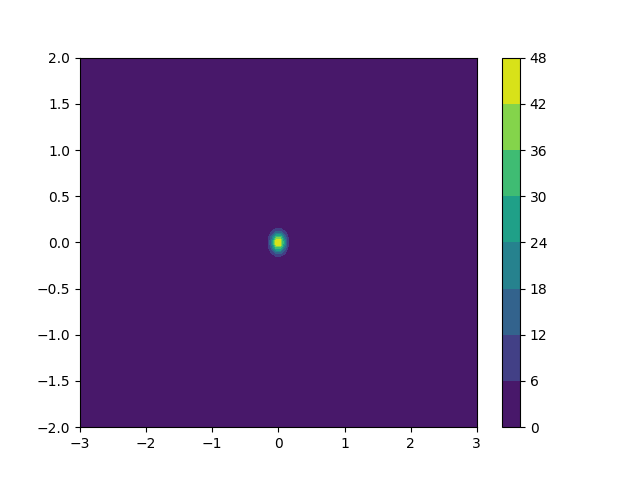

In [59]:
fig, ax = plt.subplots()
cs = ax.contourf(X, Y, z)

# Alternatively, you can manually set the levels
# and the norm:
# lev_exp = np.arange(np.floor(np.log10(z.min())-1),
#                    np.ceil(np.log10(z.max())+1))
# levs = np.power(10, lev_exp)
# cs = ax.contourf(X, Y, z, levs, norm=colors.LogNorm())

cbar = fig.colorbar(cs)

plt.show()